**Advanced Trend + Timing Strategy (Level 3)**

Author: Luke Williams

This strategy combines multi-layered trend detection, dip-buying logic, and dynamic sell signals for smarter entries and exits:


1.   Go Long when both long- and short-term EMAs show strength, RSI confirms momentum, and recent price action supports an uptrend.
2.   Buy Dips only within strong bull trends when short-term weakness creates opportunity.
3.   Exit to Cash when trend momentum deteriorates or a bearish reversal is detected using slope and curvature.
4.   Optional panic-buying triggers during deep drawdowns for index assets, adding contrarian exposure.

Performance is benchmarked against Buy and Hold using Sharpe Ratio, CAGR, Volatility, and Max Drawdown.

This is **Level 3** of the strategy framework—integrating trend structure, timing models, and advanced risk control. It’s the most dynamic and adaptable system in the series. (**Level 4** builds upon this work with enhancements to derivatives and second derivatives as well as other enhancements in signal logic.)


In [6]:
#pip install ta

In [7]:
#pip install backtrader

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import BDay
import ta
import backtrader as bt
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

#Functions

In [9]:
"""
Helper functions for preprocessing and indicator setup:

- parse_date(): Parses a date string in MM/DD/YY format, with a fallback to a default date if input is empty or malformed.
- is_index_ticker(): Determines whether a given ticker symbol represents a major index or index-based ETF, including common names and symbols.
- add_indicators(): Enhances the input DataFrame with technical indicators such as EMAs, RSIs, SMA, Bollinger Bands, and metrics related to all-time highs. These are used to support trend and momentum analysis in trading strategies.
"""
def parse_date(date_str, default):
    try:
        return datetime.strptime(date_str.strip(), '%m/%d/%y') if date_str else datetime.strptime(default, '%m/%d/%y')
    except ValueError:
        print("⚠️ Invalid format. Please use MM/DD/YY.")
        return datetime.strptime(default, '%m/%d/%y')

def is_index_ticker(ticker):
    ticker = ticker.upper()
    if ticker.startswith('^'):
        return True
    index_tickers = [
        'SPY', 'VOO', 'IVV', 'QQQ', 'DIA', 'IWM', 'VTI', 'VT',    # Popular Index ETFs
        '^GSPC', '^DJI', '^IXIC', '^RUT', '^NYA',                   # Major Indexes (S&P 500, Dow, Nasdaq, Russell 2000)
        'SPYG', 'SPYV', 'SPLG', 'VTI', 'SCHF', 'SCHB',                # Additional Index ETFs
        'S&P', 'Nasdaq', 'Russell', 'Dow', 'Global', 'Total Market'   # Common names that could be used for indices
    ]
    return ticker in index_tickers

def add_indicators(df):
    # Add Exponential Moving Averages (EMAs)
    df['EMA50'] = ta.trend.ema_indicator(df['Close'], window=50)
    df['EMA200'] = ta.trend.ema_indicator(df['Close'], window=200)
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    df['SMA10'] = df['Close'].rolling(window=10).mean()
    df['AllTimeHigh'] = df['Close'].cummax()
    df['OffATH'] = (df['Close'] - df['AllTimeHigh']) / df['AllTimeHigh']
    df['RSI2'] = ta.momentum.RSIIndicator(close=df['Close'], window=2).rsi()

    # Add Bollinger Bands
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.volatility.bollinger_hband(df['Close'], window=20), ta.trend.sma_indicator(df['Close'], window=20), ta.volatility.bollinger_lband(df['Close'], window=20)
    df.dropna(inplace=True)
    return df

In [10]:
"""
Calculates returns for a trading strategy versus a buy-and-hold benchmark:

- Computes daily percentage returns and cumulative returns for a passive Buy & Hold approach.
- Applies strategy signals to generate daily returns:
    - 'Buy' uses normal asset returns,
    - 'Sell' simulates cash returns using a configurable interest rate,
    - All other periods assume 2x leveraged exposure by default.
- Returns a DataFrame with both strategy and benchmark return series for performance comparison.
"""
def calc_returns(data, cash_rate=0.03):
    data = data.copy()

    # Calculate daily cash return
    daily_cash_rate = (1 + cash_rate)**(1/252) - 1
    # Calculate normal daily returns
    data['Returns'] = data['Close'].pct_change()
    data['BuyHold']= (1 + data['Returns'].fillna(0)).cumprod()

    # Generate strategy column from shifted signals
    data['Strategy'] = data['Signal'].shift()

    # Initialize Daily_ret with "Else" condition (2x return)
    data['Daily_ret'] = 2 * data['Returns']

    # Apply strategy conditions
    data.loc[data['Strategy'] == 'Buy', 'Daily_ret'] = data['Returns']
    data.loc[data['Strategy'] == 'Sell', 'Daily_ret'] = daily_cash_rate

    # Calculate cumulative return
    data['Strat_ret'] = (1 + data['Daily_ret'].fillna(0)).cumprod()

    return data

In [11]:
"""
Computes key performance metrics for both the strategy and a Buy & Hold benchmark:

- Calculates cumulative return, annualized return, annualized volatility, Sharpe Ratio (excess return over risk-free rate), and maximum drawdown.
- Converts daily returns into performance statistics assuming 252 trading days per year.
- Returns results in a dictionary format for easy display or logging.
"""
def calculate_metrics(df, risk_free_rate=0.03):
    df = df.copy()

    daily_rf = (1 + risk_free_rate) ** (1 / 252) - 1
    strat_daily = df['Daily_ret'].dropna()
    buyhold_daily = df['Returns'].dropna()

    metrics = {}

    def compute_stats(returns, label):
        cumulative = (1 + returns).prod() - 1
        annualized_return = (1 + cumulative) ** (252 / len(returns)) - 1
        annualized_vol = returns.std() * np.sqrt(252)
        sharpe = (annualized_return - risk_free_rate) / annualized_vol if annualized_vol > 0 else np.nan
        cumulative_curve = (1 + returns).cumprod()
        peak = cumulative_curve.cummax()
        drawdown = (cumulative_curve - peak) / peak
        max_drawdown = drawdown.min()

        return {
            f'{label} Cumulative Return': cumulative,
            f'{label} Annualized Return': annualized_return,
            f'{label} Annualized Volatility': annualized_vol,
            f'{label} Sharpe Ratio': sharpe,
            f'{label} Max Drawdown': max_drawdown
        }

    metrics.update(compute_stats(strat_daily, 'Strategy'))
    metrics.update(compute_stats(buyhold_daily, 'BuyHold'))

    return metrics

In [12]:
"""
Plots price chart with color-coded line segments based on trading signals:

- Uses lime for "Buy (Dip in Bull Trend)", black for regular "Buy", red for "Sell", and gray for no signal.
- Adds EMA50 and EMA200 trend lines for visual context.
- Dynamically adjusts x-axis date formatting based on chart duration.
- Creates a custom legend to clearly distinguish signal types.
- Helps visually analyze how the strategy executed trades across time.
"""
def plot_signals_colored(data, ticker='Ticker'):
    data = data.sort_index()
    x_dates = data.index.to_pydatetime()
    x = mdates.date2num(x_dates)
    y = data['Close'].values

    # Create line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Assign colors
    colors = []
    for i in range(len(data) - 1):
        signal = data['Signal'].iloc[i]
        if signal == 'Buy (Dip in Bull Trend)':
            colors.append('lime')
        elif signal == 'Buy':
            colors.append('black')
        elif signal == 'Sell':
            colors.append('red')
        else:
            colors.append('gray')

    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data.index, data['EMA50'], label='EMA50', linestyle='--')
    ax.plot(data.index, data['EMA200'], label='EMA200', linestyle='--')
    lc = LineCollection(segments, colors=colors, linewidths=2)
    ax.add_collection(lc)

    # Dynamic x-axis formatting
    date_range = x_dates[-1] - x_dates[0]
    years_span = date_range.days / 365.25

    if years_span < 3:
        locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
        formatter = mdates.DateFormatter('%Y-%m')
    elif years_span < 6:
        locator = mdates.MonthLocator(bymonth=[1, 7])
        formatter = mdates.DateFormatter('%Y-%m')
    else:
        locator = mdates.YearLocator()
        formatter = mdates.DateFormatter('%Y')

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()

    # Custom legend entries
    handles, labels = ax.get_legend_handles_labels()

    # Add custom legend handles for colors
    handles.append(plt.Line2D([0], [0], color='lime', lw=2))  # Lime for Buy Dip
    handles.append(plt.Line2D([0], [0], color='black', lw=2))  # Black for Buy
    handles.append(plt.Line2D([0], [0], color='red', lw=2))    # Red for Sell

    labels.append('2x Levered Buy')
    labels.append('Buy')
    labels.append('Sell')

    # Final touches
    x_buffer = (x.max() - x.min()) * 0.01  # 1% of the range
    ax.set_xlim(x.min(), x.max() + x_buffer)
    ax.set_ylim(y.min() * 0.98, y.max() * 1.02)
    ax.set_title(f'{ticker.upper()} Trading Signals (Colored Price Line)')
    ax.legend(handles=handles, labels=labels, loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
"""
Plots cumulative returns for both the strategy and a buy-and-hold benchmark:

- Compares performance visually over time using 'Strat_ret' and 'BuyHold' columns.
- Displays the cumulative growth of each approach, helping evaluate strategy effectiveness.
- Adds titles, labels, legend, grid, and date formatting for clarity.
- Alerts the user if required return columns are missing from the input data.
"""
def plot_cumulative_returns(data, ticker):
    # Check if the necessary columns exist
    if 'BuyHold' in data.columns and 'Strat_ret' in data.columns:
        # Plot the cumulative returns for both strategy and buy-and-hold
        plt.figure(figsize=(14, 6))  # Match the figure size to previous plots

        # Plot the Buy & Hold and Strategy cumulative returns
        plt.plot(data.index, data['BuyHold'], label='Buy & Hold', color='blue', linestyle='-', linewidth=2)
        plt.plot(data.index, data['Strat_ret'], label='Strategy', color='green', linestyle='-', linewidth=2)

        # Add titles and labels
        plt.title(f'Cumulative Returns {ticker.upper()}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Cumulative Return', fontsize=14)

        # Show the legend
        plt.legend(loc='upper left')

        # Add a grid for easier readability
        plt.grid(True)

        # Rotate date labels for better readability
        plt.xticks(rotation=45)

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print("The necessary columns 'BuyHold' and 'Strat_ret' are not found in the data.")


In [14]:
"""
Main strategy execution pipeline that:

1. Loads historical price data for a given `ticker`, with buffer to compute indicators.
2. Applies technical indicators and signal logic, accounting for whether the asset is an index.
3. Computes both buy-and-hold and strategy-based returns and key performance metrics.
4. Prints a formatted performance summary (if `verbose=True`), including Sharpe, drawdowns, and return multiples.
5. Returns the full dataframe with returns/signals and a dictionary of performance metrics.

Helper functions:
- `load_data()`: Downloads price data with a buffer for indicators.
- `get_user_inputs()`: Prompts for ticker, date range, and cash yield.
- `print_results()`: Outputs a detailed side-by-side comparison of strategy vs. buy-and-hold.
- 'run_strategy()': Orchestrates the entire strategy execution for a given ticker and date range.
"""

def load_data(ticker, start, end):
    buffer = 300
    start_date = datetime.strptime(start, "%Y-%m-%d")
    adjusted_start = (start_date - BDay(buffer)).date()
    df = yf.download(ticker, start=adjusted_start, end=end, progress=False, auto_adjust=False)
    df.columns = df.columns.get_level_values(0)
    return df, start_date

def get_user_inputs():
    from datetime import datetime
    today = datetime.today().strftime('%m/%d/%y')
    ticker = (input("Enter ticker Symbol [SPY]: ") or 'SPY').upper()
    start = parse_date(input("Start date [1/1/20]: "), '01/01/20').strftime('%Y-%m-%d')
    end = parse_date(input("End date [today]: "), today).strftime('%Y-%m-%d')
    cash = float(input("Cash yield [3%]: ") or 3) / 100
    return ticker, start, end, cash

def print_results(last_signal, metrics, ticker, start, end):
    print(f"\n📊 Strategy Performance for {ticker.upper()} | {start} → {end}\n")

    def format_return(label):
        pct = metrics[f'{label} Cumulative Return']
        multiplier = 1 + pct
        return f"{pct:.1%} ({multiplier:.2f}x)"

    print("🔹 **Strategy:**\n")
    print(f"   🏆 Sharpe Ratio      : {metrics['Strategy Sharpe Ratio']:.2f}")
    print(f"   📈 Annual Return     : {metrics['Strategy Annualized Return']:.1%}")
    print(f"   📊 Volatility        : {metrics['Strategy Annualized Volatility']:.1%}")
    print(f"   📈 Cumulative Return : {format_return('Strategy')}")
    print(f"   📉 Max Drawdown      : {metrics['Strategy Max Drawdown']:.1%}\n")
    print(f"   🔔 Last Action: {last_signal}\n")

    # Create the header and section for buy & hold performance
    print("🔹 **Buy & Hold:**\n")
    print(f"   🏆 Sharpe Ratio      : {metrics['BuyHold Sharpe Ratio']:.2f}")
    print(f"   📈 Annual Return     : {metrics['BuyHold Annualized Return']:.1%}")
    print(f"   📊 Volatility        : {metrics['BuyHold Annualized Volatility']:.1%}")
    print(f"   📈 Cumulative Return : {format_return('BuyHold')}")
    print(f"   📉 Max Drawdown      : {metrics['BuyHold Max Drawdown']:.1%}")


def run_strategy(ticker, start, end, cash=0.03, verbose=True):
    is_index = is_index_ticker(ticker)
    data, start_date = load_data(ticker, start, end)
    data = add_indicators(data)
    data = apply_signal_logic(data, start_date, is_index)
    data = calc_returns(data, cash)
    metrics = calculate_metrics(data, risk_free_rate=cash)
    last_signal = data['Signal'].iloc[-1]  # Get the last signal
    if verbose:
        print_results(last_signal, metrics, ticker, start, end)
    return data, metrics

#Signal Logic

In [15]:
"""
Applies a comprehensive set of technical rules to generate buy/sell signals.

The function uses a combination of EMA trends, RSI conditions, price action,
and statistical filters to determine:
- Bull trend identification
- Dip buying opportunities within a trend
- Early uptrend signals
- RSI divergence
- Sell signals based on weakening trends or downward momentum
- Panic dip buys for indices (e.g., major pullbacks with RSI2 < 10)

Args:
    data (pd.DataFrame): A DataFrame indexed by date with the following columns:
        ['Close', 'EMA50', 'EMA200', 'RSI', 'RSI2', 'SMA10', 'OffATH',
          'BB_upper', 'BB_lower', 'BB_middle', 'High', 'Low', 'Volume', 'Adj Close'].
    start_date (str or pd.Timestamp, optional): Filter the output to only include rows
        from this date onward. Format should be 'YYYY-MM-DD' or a valid Timestamp.
    is_index (bool): If True, enables logic specific to index-level panic dip buys.

Returns:
    pd.DataFrame: The original DataFrame with extraneous columns dropped, and an added 'Signal' column
    indicating:
        - 'Buy (Dip in Bull Trend)'
        - 'Buy'
        - 'Sell'
        or NaN for no signal.
Notes:
    - Signals are forward-filled and filtered to remove invalid dip buys below the long-term trend (EMA200).
    - The strategy assumes pre-computed indicators (e.g., EMA50, RSI, etc.) are present in the input DataFrame.
"""

def apply_signal_logic(data, start_date=None, is_index=False):
    data = data.copy()
    signals = []
    bull_trends = []
    dip_buys = []
    sell_signals = []
    uptrends = []
    price_trends = []
    start_index = data['EMA200'].first_valid_index()
    start_i = data.index.get_loc(start_index)
    for i in range(len(data)):
        row = data.iloc[i]

        if i < start_i or np.isnan(row['EMA50']) or np.isnan(row['RSI']):
            signals.append(None)
            bull_trends.append(False)
            dip_buys.append(False)
            sell_signals.append(False)
            uptrends.append(False)
            price_trends.append(False)
            continue

        # Trend Identification
        ema50_trend = data['EMA50'].iloc[i-10:i].diff().mean()
        ema200_trend = data['EMA200'].iloc[i-10:i].diff().mean()
        ema50_slope_10 = data['EMA50'].iloc[i] - data['EMA50'].iloc[i-10]
        uptrend = row['EMA50'] > row['EMA200'] and ema50_trend > 0 and ema200_trend > 0 and row['RSI'] > 50

        # 3+ higher highs and lows in past 20 days
        past_20 = data.iloc[i-20:i]
        # Using a 10-day moving average as a simple trend indicator
        price_above_sma10 = row['Close'] > row['SMA10']
        price_action_trend = price_above_sma10

        # New Bull Trend Logic
        price_above_ema200_recent = (
            data['Close'].iloc[i-60:i] > data['EMA200'].iloc[i-60:i]).mean() >= .95  # 80% of the last 60 days
        ema200_slope = row['EMA200'] > data['EMA200'].iloc[i-5]  # upward slope

        #past_252 = data['Close'].iloc[i-252:i]  # 252 trading days ≈ 52 weeks
        #close_to_52w_high = row['Close'] >= (past_252.max() * 0.9)
        # Calculate slope of EMA50 over the last 10 days (more reactive)

        # Optionally smooth with average slope (less noisy)
        # ema50_slope_avg = data['EMA50'].iloc[i-10:i].diff().mean()

        # Require EMA200 to be upward AND EMA50 slope to be significant
        bull_trend = (
            price_above_ema200_recent and
            ema200_slope and
            ema50_slope_10 > .05 and
            row['Close'] > row['EMA200']
        )
        # Add a buffer to check consecutive days of price action below EMA50
        dip_buy = (
            row['Close'] < row['EMA50'] and
            row['RSI'] < 40 and
            row['Close'] > row['EMA200'] and  # only allow dip buys above long-term trend
            (data['Close'].iloc[i-1] < data['EMA50'].iloc[i-1])  # previous day also a dip
        )

        ema50_today = row['EMA50']
        ema50_yesterday = data['EMA50'].iloc[i-1]
        ema50_day_before = data['EMA50'].iloc[i-2]

        if i >= 2:
            price_now = row['Close']
            price_prev = data['Close'].iloc[i-1]
            price_prev2 = data['Close'].iloc[i-2]

            rsi_now = row['RSI']
            rsi_prev = data['RSI'].iloc[i-1]
            rsi_prev2 = data['RSI'].iloc[i-2]

            # Price making lower lows
            price_lower_low = price_now < price_prev and price_prev < price_prev2
            # RSI making higher lows
            rsi_higher_low = rsi_now > rsi_prev and rsi_prev > rsi_prev2

            rsi_divergence = price_lower_low and rsi_higher_low
        else:
            rsi_divergence = False

        first_diff = ema50_today - ema50_yesterday
        second_diff = ema50_yesterday - ema50_day_before

        concavity = first_diff - second_diff  # approx 2nd derivative

        ema50_slope_50 = data['EMA50'].iloc[i] - data['EMA50'].iloc[i-50]
        sell_signal = (
            row['RSI'] < 50 and
            row['Close'] < row['EMA50'] and
            row['EMA50'] < row['EMA200'] and
            concavity < 0  or
            ema50_slope_50 < 0
        )
        # Time bottoms when:
        bottoming_candidate = (
            row['Close'] > row['EMA50'] and
            data['EMA50'].iloc[i] > data['EMA50'].iloc[i-10]  # upward EMA50 slope
        )

        off_ath = row['OffATH']  # how far below ATH
        rsi2_oversold = row['RSI2'] < 10  # loosen a little
        #price_near_ema200 = row['Close'] > row['EMA200'] * 0.9  # within 5% of EMA200
        if is_index:
            panic_dip_buy = off_ath <= -0.20 and rsi2_oversold
        else:
            panic_dip_buy = False  # no dip buy for individual stocks


        # Final Signal Logic
        if bull_trend and dip_buy:
            signal = 'Buy (Dip in Bull Trend)'
        elif uptrend and price_action_trend or bottoming_candidate or panic_dip_buy: # or early_bottoming:
            signal = 'Buy'
        elif sell_signal:
            signal = 'Sell'
        else:
            signal = pd.NA

        # Append results
        signals.append(signal)
        bull_trends.append(bull_trend)
        dip_buys.append(dip_buy)
        sell_signals.append(sell_signal)
        uptrends.append(uptrend)
        price_trends.append(price_action_trend)
    # Add everything to the DataFrame
    data['Signal'] = signals
    data = data.drop(['High', 'Adj Close', 'Low', 'Volume', 'RSI', 'SMA10','BB_upper','BB_lower','BB_middle'], axis=1)
    data['Signal'] = data['Signal'].mask((data['Signal'] == 0) | (data['Signal'].isna())).ffill()
    # Replace invalid dip buys (where price < EMA200) with Sell
    buffer=.01
    data.loc[
        (data['Signal'] == 'Buy (Dip in Bull Trend)') & (data['Close'] < data['EMA200']* (1 - buffer)),
        'Signal'
    ] = 'Sell'

    if start_date:
        data = data[data.index >= start_date]
    data = data.dropna()

    return data


#'Main' Function

In [16]:
"""
Main entry point for executing the trading strategy workflow.

- Prompts the user for ticker, date range, and cash yield.
- Runs the trading strategy and computes performance metrics.
- Plots trading signals and cumulative returns.

"""
def main():
    ticker, start, end, cash = get_user_inputs()
    df , metrics = run_strategy(ticker, start, end, cash)
    plot_signals_colored(df, ticker)
    plot_cumulative_returns(df, ticker)

#Run and Input stock and other variables.

Enter ticker Symbol [SPY]: 
Start date [1/1/20]: 
End date [today]: 
Cash yield [3%]: 

📊 Strategy Performance for SPY | 2020-01-01 → 2025-05-06

🔹 **Strategy:**

   🏆 Sharpe Ratio      : 0.69
   📈 Annual Return     : 14.7%
   📊 Volatility        : 16.9%
   📈 Cumulative Return : 107.9% (2.08x)
   📉 Max Drawdown      : -26.5%

   🔔 Last Action: Sell

🔹 **Buy & Hold:**

   🏆 Sharpe Ratio      : 0.36
   📈 Annual Return     : 10.9%
   📊 Volatility        : 21.7%
   📈 Cumulative Return : 73.5% (1.73x)
   📉 Max Drawdown      : -34.1%


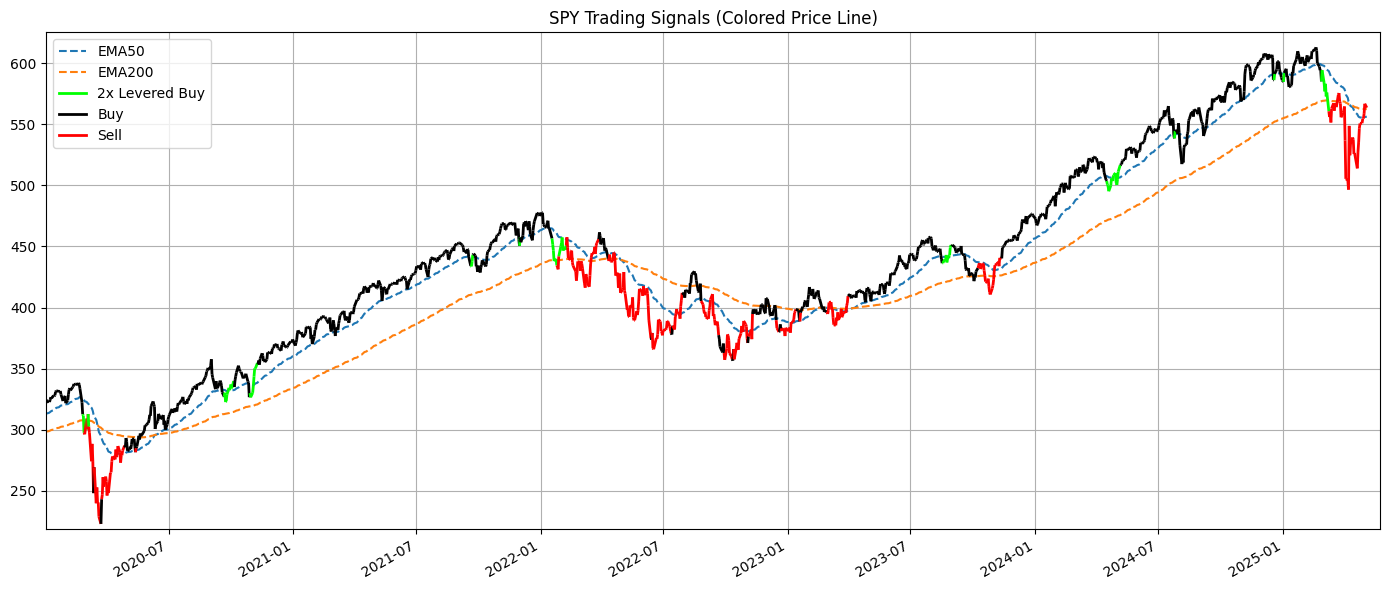

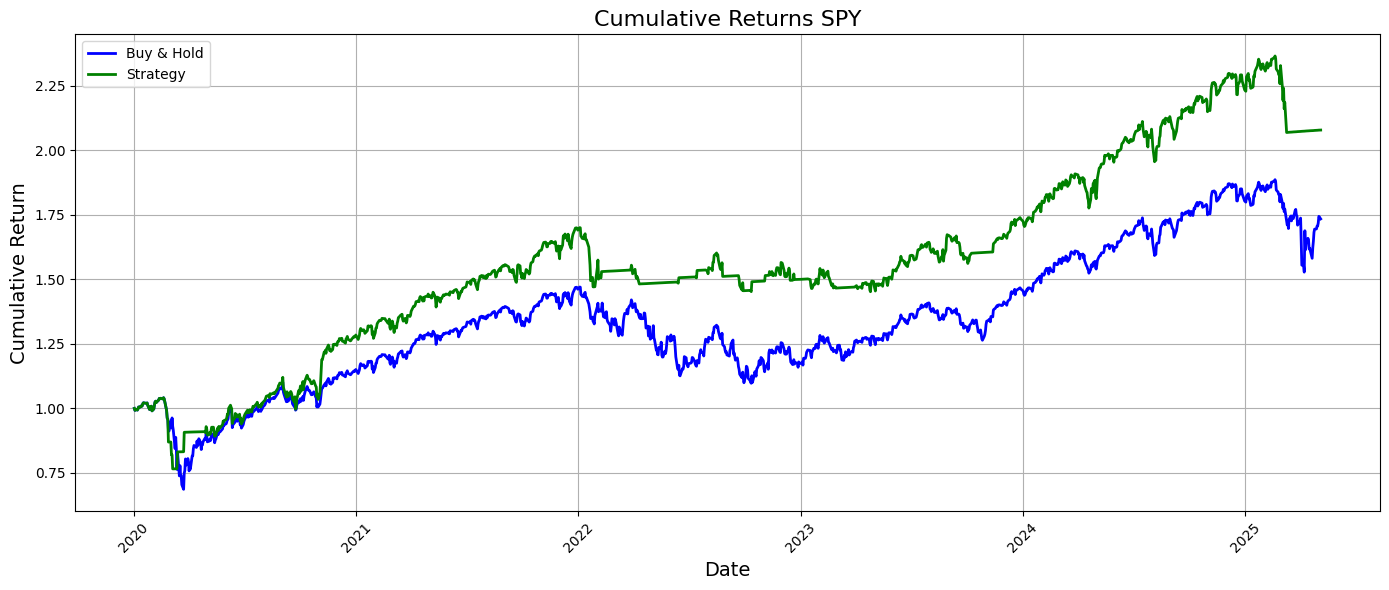

In [17]:
if __name__ == '__main__':
    main()